In [1]:
import os
import multiprocessing

import pickle

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy.stats import norm

from copy import deepcopy
import itertools
import random

from collections import OrderedDict


import torch
import torch.nn as nn


from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(1)


blue = '#0073B7'
yellow = '#FFD23F'
gray = '#7A7A7A'
purple = '#B05AA3'
green = '#00A651'
orange = '#F7941D'


blue_yellow = LinearSegmentedColormap.from_list(
    "blue_yellow", ["#0073B7", "#FFD23F"]
)


gray = '#C0C0C0'
purple = '#B05AA3'

gray_purple = LinearSegmentedColormap.from_list(
    "gray_purple",
    [gray , purple]
)


blue_distribution = '#00AEEF'
red_distribution = '#F15A2A'


os.environ["OMP_NUM_THREADS"]="1"
os.environ["MKL_NUM_THREADS"]="1"
os.environ["OPENBLAS_NUM_THREADS"]="1"
os.environ["NUMEXPR_NUM_THREADS"]="1"
os.environ["MKL_DYNAMIC"]="FALSE"
torch.set_num_threads(1)
torch.set_num_interop_threads(1)
multiprocessing.set_start_method("fork")

In [2]:
from src.model_simple import SSCNetwork
from src.utils.general import make_input, LatentSpace, get_ordered_indices, test_network, get_cos_sim_torch
from src.utils.plotting import compare_distributions_12

from network_parameters import network_parameters

from Figure_7_utils import higher_order_selectivity

In [3]:
#make network randomly project sensory input to obtain a wide distribution of selectivity in MTL-sensory
network_parameters["mtl_dense_sen_projection"] = True
network_parameters["mtl_dense_sen_size"] = 30
network_parameters["max_post_mtl_dense_sen"] = 1
network_parameters["max_pre_mtl_dense_sen"] = np.inf

recording_parameters = {}
recording_parameters["regions"] = ["mtl_dense", "mtl_sparse", "mtl", "ctx"]
recording_parameters["rate_activity"] = np.inf
recording_parameters["connections"] = ["ctx_mtl"]
recording_parameters["rate_connectivity"] = np.inf

input_params = {}
input_params["num_days"] = 1
input_params["day_length"] = 80
input_params["mean_duration"] = 5
input_params["fixed_duration"] = True
input_params["num_swaps"] = 4


latent_specs = {}
latent_specs["num"] = 2
latent_specs["total_sizes"] = [50, 50]
latent_specs["act_sizes"] = [10, 10]
latent_specs["dims"] = [5, 5]
latent_specs["prob_list"] = [0.5/5 if i==j else 0.5/20 for i in range(5) for j in range(5)]

In [4]:


num_cpu = 100
modes = ["intact", "scrambled"]
num_seeds = 20
seeds = np.arange(num_seeds)
seeds = [int(s) for s in np.asarray(seeds).ravel().tolist()]



In [5]:
initial_network_path = "checkpoints/network_6_best.pt"
experiment_params = [(mode, seed, recording_parameters, input_params, latent_specs, initial_network_path) for mode in modes for seed in seeds]
pool = multiprocessing.Pool(processes=num_cpu)

results_list = pool.starmap(higher_order_selectivity, experiment_params)

0
0
0
0
00

0
0
00

0
0
00

000


0
0
0
000


00

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


KeyboardInterrupt: 

In [6]:

def save_results(results_list, filename):


    results = {}
    results["selectivity_ctx_episodes"] = []


    for selectivity_ctx_episodes in results_list:


        results["selectivity_ctx_episodes"].append(selectivity_ctx_episodes)

    with open('Data/{}'.format(filename), 'wb') as handle:
        pickle.dump(dict(results), handle, protocol=pickle.HIGHEST_PROTOCOL)


save_results(results_list, filename='fig_7_higher_order_selectivity_best.pickle')

In [5]:
with open('Data/{}'.format('fig_7_higher_order_selectivity_best.pickle'), 'rb') as handle:
    results = pickle.load(handle)

/home/aa10522/Desktop/sensory-semantic-episodes/src/utils/plotting.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=groups, y=data, inner=None, cut=0, alpha=0.9, palette=palette)


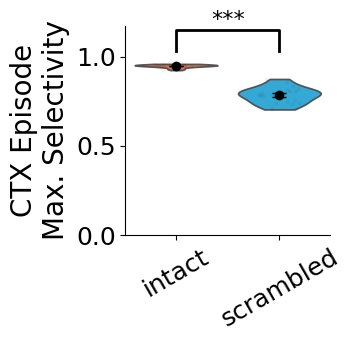

In [6]:


# Flatten arrays
interleaved_acc = np.array(results["selectivity_ctx_episodes"][:num_seeds]).flatten()
blocked_acc = np.array(results["selectivity_ctx_episodes"][num_seeds:]).flatten()


dist1 = ('intact', interleaved_acc)
dist2 = ('scrambled', blocked_acc)

palette = {
    "intact": red_distribution,   # light blue
    "scrambled": blue_distribution
}

compare_distributions_12(dist1, dist2, palette)
plt.ylabel("CTX Episode\nMax. Selectivity", fontsize=20)
plt.xticks(fontsize=18, rotation=30)
plt.yticks([0, 0.5, 1], fontsize=18)
plt.tight_layout()
sns.despine()


plt.savefig('Figures_SVG/7f.svg', dpi=300, transparent=True)

In [8]:
initial_network_path = "checkpoints/network_6_best.pt"
median_seed = np.argsort(np.array(results["selectivity_ctx_episodes"]))[num_seeds//2]
network = higher_order_selectivity('intact', int(median_seed), recording_parameters, input_params, latent_specs, initial_network_path, get_network=True)

0
50
100
150
200
250
300
350
400
450


In [9]:
network.init_recordings(recording_parameters)
network.frozen = False
network.activity_recordings_rate = 1
network.connectivity_recordings_rate = 1

input_params["num_days"] = 1
input_params["latent_space"] = LatentSpace(**latent_specs)

input, input_episodes, input_latents, network = test_network(network, input_params, sleep=True, print_rate=50)

0


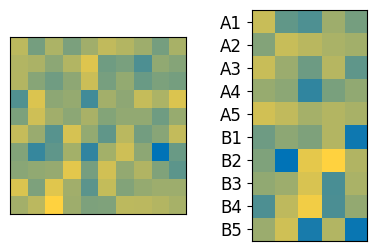

In [10]:
h_random = torch.randn(network.mtl_size)
mtl = h_random





fig, ax = plt.subplots(1, 2, figsize=(5, 3))
ax[0].imshow(mtl[:100].reshape((-1, 10)), cmap=blue_yellow)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].imshow(mtl[100:][network.ordered_indices_mtl_sparse[:50]].reshape((-1, 5)), cmap=blue_yellow)


# Example parameters
N = 10  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * i for i in range(NA + NB)]
ax[1].set_yticks(positions, labels, fontsize=12)

plt.savefig('Figures_SVG/7b1.svg', dpi=300, transparent=True)

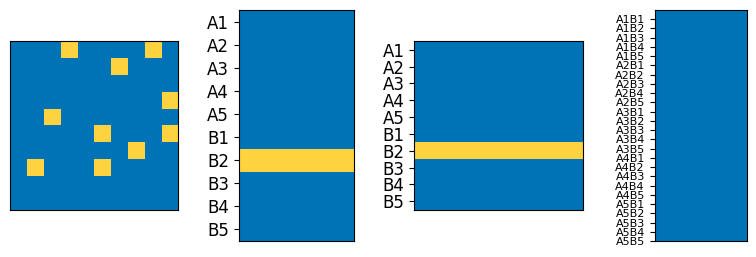

In [11]:
semantic_charge = 1
mtl_sparsity = (semantic_charge/network.max_semantic_charge_input)*network.mtl_sparsity.clone()
mtl = network.pattern_complete('mtl', h_0=h_random, sparsity=mtl_sparsity)


ctx_hat = F.linear(mtl, network.ctx_mtl) + network.ctx_b*network.ctx_IM
ctx, _ = network.activation(ctx_hat, 'ctx', sleep=True, subregion_index=0)



fig, ax = plt.subplots(1, 4, figsize=(10, 3))
ax[0].imshow(mtl[:100].reshape((-1, 10)), cmap=blue_yellow)
ax[1].imshow(mtl[100:][network.ordered_indices_mtl_sparse[:50]].reshape((-1, 5)), cmap=blue_yellow)
ax[2].imshow(ctx[network.ordered_indices_ctx][:100].reshape((-1, 10)), cmap=blue_yellow)
ax[3].imshow(ctx[network.ordered_indices_ctx][100:350].reshape((-1, 10)), cmap=blue_yellow)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[3].set_xticks([])


# Example parameters
N = 10  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B
# Positions for labels (centered in each segment)
positions = [M * i for i in range(NA + NB)]


ax[1].set_yticks(positions, labels, fontsize=12)

# Example parameters
N = 10  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B
# Positions for labels (centered in each segment)
positions = [M * i for i in range(NA + NB)]

ax[2].set_yticks(positions, labels, fontsize=12)




# Example parameters
N = 25  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA * NB)  # Size of each group (equal-sized segments for each AiBj)

# Generate combination labels
labels_episodes = [f"A{i+1}B{j+1}" for i in range(NA) for j in range(NB)]

# Positions for labels (centered in each segment)
positions_episodes = [M * (k + 0.5) for k in range(NA * NB)]


ax[3].set_yticks(positions_episodes, labels_episodes, fontsize=8)

plt.savefig('Figures_SVG/7b2.svg', dpi=300, transparent=True)

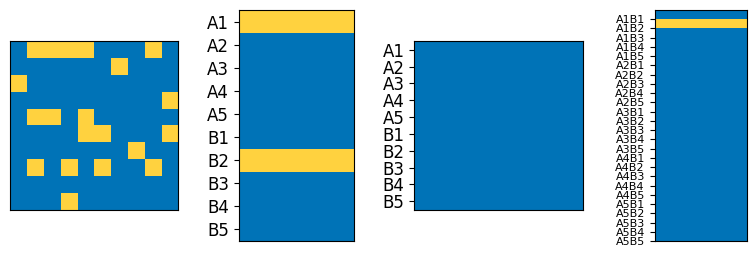

In [12]:
semantic_charge = 2
mtl_sparsity = (semantic_charge/network.max_semantic_charge_input)*network.mtl_sparsity.clone()
mtl = network.pattern_complete('mtl', h_0=h_random, sparsity=mtl_sparsity)


ctx_hat = F.linear(mtl, network.ctx_mtl) + network.ctx_b*network.ctx_IM
ctx, _ = network.activation(ctx_hat, 'ctx', sleep=True, subregion_index=1)



fig, ax = plt.subplots(1, 4, figsize=(10, 3))
ax[0].imshow(mtl[:100].reshape((-1, 10)), cmap=blue_yellow)
ax[1].imshow(mtl[100:][network.ordered_indices_mtl_sparse[:50]].reshape((-1, 5)), cmap=blue_yellow)
ax[2].imshow(ctx[:100].reshape((-1, 10)), cmap=blue_yellow)
ax[3].imshow(ctx[network.ordered_indices_ctx_episodes][:250].reshape((-1, 10)), cmap=blue_yellow)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[3].set_xticks([])

# Example parameters
N = 10  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B
# Positions for labels (centered in each segment)
positions = [M * i for i in range(NA + NB)]


ax[1].set_yticks(positions, labels, fontsize=12)


# Example parameters
N = 10  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B
# Positions for labels (centered in each segment)
positions = [M * i for i in range(NA + NB)]

ax[2].set_yticks(positions, labels, fontsize=12)

# Example parameters
N = 25  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA * NB)  # Size of each group (equal-sized segments for each AiBj)

# Generate combination labels
labels_episodes = [f"A{i+1}B{j+1}" for i in range(NA) for j in range(NB)]

# Positions for labels (centered in each segment)
positions_episodes = [M * (k + 0.5) for k in range(NA * NB)]


ax[3].set_yticks(positions_episodes, labels_episodes, fontsize=8)


plt.savefig('Figures_SVG/7b3.svg', dpi=300, transparent=True)

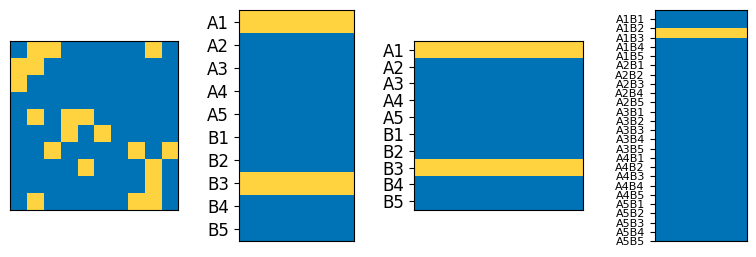

In [13]:
mtl = torch.stack(network.activity_recordings["mtl"], axis=0)[network.awake_indices][-1]
ctx = torch.stack(network.activity_recordings["ctx"], axis=0)[network.awake_indices][-1]


fig, ax = plt.subplots(1, 4, figsize=(10, 3))
ax[0].imshow(mtl[:100].reshape((-1, 10)), cmap=blue_yellow)
ax[1].imshow(mtl[100:][network.ordered_indices_mtl_sparse[:50]].reshape((-1, 5)), cmap=blue_yellow)
ax[2].imshow(ctx[network.ordered_indices_ctx][:100].reshape((-1, 10)), cmap=blue_yellow)
ax[3].imshow(ctx[network.ordered_indices_ctx_episodes][:250].reshape((-1, 10)), cmap=blue_yellow)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[3].set_xticks([])

# Example parameters
N = 10  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B
# Positions for labels (centered in each segment)
positions = [M * i for i in range(NA + NB)]


ax[1].set_yticks(positions, labels, fontsize=12)


# Example parameters
N = 10  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B
# Positions for labels (centered in each segment)
positions = [M * i for i in range(NA + NB)]

ax[2].set_yticks(positions, labels, fontsize=12)

# Example parameters
N = 25  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA * NB)  # Size of each group (equal-sized segments for each AiBj)

# Generate combination labels
labels_episodes = [f"A{i+1}B{j+1}" for i in range(NA) for j in range(NB)]

# Positions for labels (centered in each segment)
positions_episodes = [M * (k + 0.5) for k in range(NA * NB)]


ax[3].set_yticks(positions_episodes, labels_episodes, fontsize=8)


plt.savefig('Figures_SVG/7c.svg', dpi=300, transparent=True)

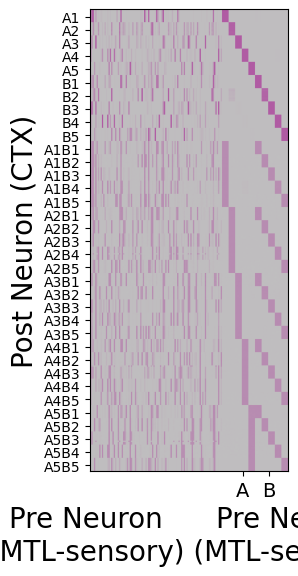

In [14]:
full_ordered_indices_ctx = torch.cat([
    network.ordered_indices_ctx[:100],
    network.ordered_indices_ctx_episodes[:250]
])


# Compute the full indexing array
full_ordered_indices = torch.cat([
    torch.arange(100),
    network.mtl_dense_size + network.ordered_indices_mtl_sparse
])


fig = plt.figure(figsize=(5, 6))

plt.imshow(network.ctx_mtl[full_ordered_indices_ctx][:, full_ordered_indices[:150]], cmap=gray_purple)


# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i + 0.5) for i in range(NA + NB)]


# Example parameters
N = 250  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA * NB)  # Size of each group (equal-sized segments for each AiBj)

# Generate combination labels
labels_episodes = [f"A{i+1}B{j+1}" for i in range(NA) for j in range(NB)]

# Positions for labels (centered in each segment)
positions_episodes = [100 + M * (k + 0.5) for k in range(NA * NB)]

positions.extend(positions_episodes)
labels.extend(labels_episodes)

plt.yticks(positions, labels)

plt.xticks([115, 135], ["A", "B"],  fontsize=14)
plt.xlabel("Pre Neuron      Pre Neuron\n  (MTL-sensory) (MTL-semantic)", fontsize=20)
plt.ylabel("Post Neuron (CTX)", fontsize=20)
plt.savefig('Figures_SVG/7d.svg', dpi=300, transparent=True)


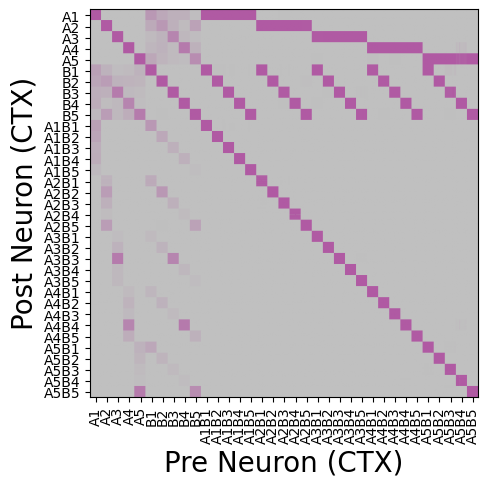

In [15]:

fig = plt.figure(figsize=(5, 6))


plt.imshow(network.ctx_ctx[full_ordered_indices_ctx][:, full_ordered_indices_ctx], cmap=gray_purple)


# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i + 0.5) for i in range(NA + NB)]


# Example parameters
N = 250  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA * NB)  # Size of each group (equal-sized segments for each AiBj)

# Generate combination labels
labels_episodes = [f"A{i+1}B{j+1}" for i in range(NA) for j in range(NB)]

# Positions for labels (centered in each segment)
positions_episodes = [100 + M * (k + 0.5) for k in range(NA * NB)]

positions.extend(positions_episodes)
labels.extend(labels_episodes)

plt.yticks(positions, labels)
plt.xticks(positions, labels, rotation=90)


plt.xlabel("Pre Neuron (CTX)", fontsize=20)
plt.ylabel("Post Neuron (CTX)", fontsize=20)

plt.savefig('Figures_SVG/7e.svg', dpi=300, transparent=True)


In [9]:
initial_network_path = "checkpoints/network_6_median.pt"
experiment_params = [(mode, seed, recording_parameters, input_params, latent_specs, initial_network_path) for mode in modes for seed in seeds]
pool = multiprocessing.Pool(processes=num_cpu)

results_list = pool.starmap(higher_order_selectivity, experiment_params)

00

0
0
0
0
00

0
0
0
00

00

0
0
00

0
0
00

0
00

0
00
0

0
00

0
0
0
0
0
0
0
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
5050

50
50
50
50
50
50
50
50
50
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150150

150
150
150
150
150
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300300

300
300
300


In [10]:

def save_results(results_list, filename):


    results = {}
    results["selectivity_ctx_episodes"] = []


    for selectivity_ctx_episodes in results_list:


        results["selectivity_ctx_episodes"].append(selectivity_ctx_episodes)

    with open('Data/{}'.format(filename), 'wb') as handle:
        pickle.dump(dict(results), handle, protocol=pickle.HIGHEST_PROTOCOL)


save_results(results_list, filename='fig_7_higher_order_selectivity_median.pickle')

In [11]:
with open('Data/{}'.format('fig_7_higher_order_selectivity_median.pickle'), 'rb') as handle:
    results = pickle.load(handle)

/home/aa10522/Desktop/sensory-semantic-episodes/src/utils/plotting.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=groups, y=data, inner=None, cut=0, alpha=0.9, palette=palette)


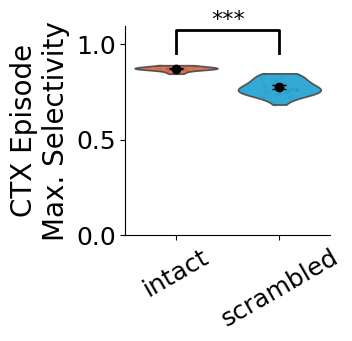

In [12]:


# Flatten arrays
interleaved_acc = np.array(results["selectivity_ctx_episodes"][:num_seeds]).flatten()
blocked_acc = np.array(results["selectivity_ctx_episodes"][num_seeds:]).flatten()


dist1 = ('intact', interleaved_acc)
dist2 = ('scrambled', blocked_acc)

palette = {
    "intact": red_distribution,   # light blue
    "scrambled": blue_distribution
}

compare_distributions_12(dist1, dist2, palette)
plt.ylabel("CTX Episode\nMax. Selectivity", fontsize=20)
plt.xticks(fontsize=18, rotation=30)
plt.yticks([0, 0.5, 1], fontsize=18)
plt.tight_layout()
sns.despine()


plt.savefig('Figures_SVG/7f_supp.svg', dpi=300, transparent=True)

In [18]:
initial_network_path = "checkpoints/network_6_median.pt"
median_seed = np.argsort(np.array(results["selectivity_ctx_episodes"]))[num_seeds//2]
network = higher_order_selectivity('intact', int(median_seed), recording_parameters, input_params, latent_specs, initial_network_path, get_network=True)

0
50
100
150
200
250
300
350
400
450


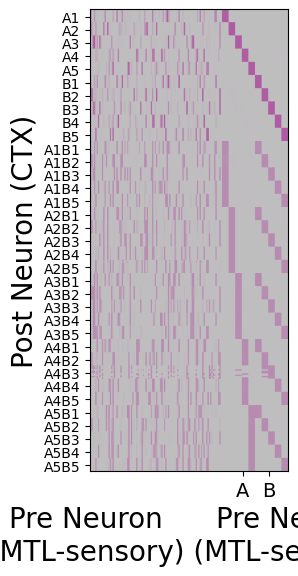

In [19]:
full_ordered_indices_ctx = torch.cat([
    network.ordered_indices_ctx[:100],
    network.ordered_indices_ctx_episodes[:250]
])


# Compute the full indexing array
full_ordered_indices = torch.cat([
    torch.arange(100),
    network.mtl_dense_size + network.ordered_indices_mtl_sparse
])


fig = plt.figure(figsize=(5, 6))

plt.imshow(network.ctx_mtl[full_ordered_indices_ctx][:, full_ordered_indices[:150]], cmap=gray_purple)


# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i + 0.5) for i in range(NA + NB)]


# Example parameters
N = 250  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA * NB)  # Size of each group (equal-sized segments for each AiBj)

# Generate combination labels
labels_episodes = [f"A{i+1}B{j+1}" for i in range(NA) for j in range(NB)]

# Positions for labels (centered in each segment)
positions_episodes = [100 + M * (k + 0.5) for k in range(NA * NB)]

positions.extend(positions_episodes)
labels.extend(labels_episodes)

plt.yticks(positions, labels)

plt.xticks([115, 135], ["A", "B"],  fontsize=14)
plt.xlabel("Pre Neuron      Pre Neuron\n  (MTL-sensory) (MTL-semantic)", fontsize=20)
plt.ylabel("Post Neuron (CTX)", fontsize=20)
plt.savefig('Figures_SVG/7d_supp.svg', dpi=300, transparent=True)


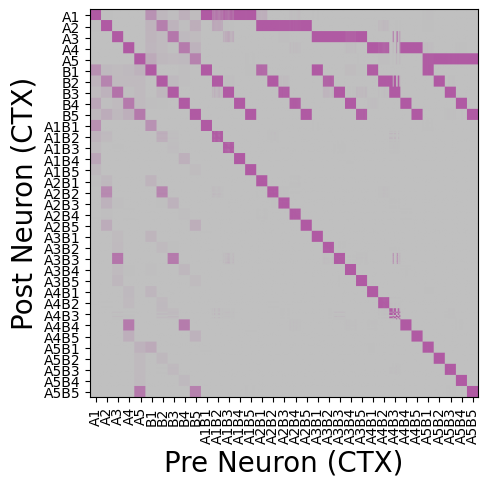

In [20]:

fig = plt.figure(figsize=(5, 6))


plt.imshow(network.ctx_ctx[full_ordered_indices_ctx][:, full_ordered_indices_ctx], cmap=gray_purple)


# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i + 0.5) for i in range(NA + NB)]


# Example parameters
N = 250  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA * NB)  # Size of each group (equal-sized segments for each AiBj)

# Generate combination labels
labels_episodes = [f"A{i+1}B{j+1}" for i in range(NA) for j in range(NB)]

# Positions for labels (centered in each segment)
positions_episodes = [100 + M * (k + 0.5) for k in range(NA * NB)]

positions.extend(positions_episodes)
labels.extend(labels_episodes)

plt.yticks(positions, labels)
plt.xticks(positions, labels, rotation=90)


plt.xlabel("Pre Neuron (CTX)", fontsize=20)
plt.ylabel("Post Neuron (CTX)", fontsize=20)

plt.savefig('Figures_SVG/7e_supp.svg', dpi=300, transparent=True)


In [54]:
input_params["num_days"] = 1
input_params["day_length"] = 10000
input_params["latent_space"] = LatentSpace(**latent_specs)
input, input_episodes, input_latents = make_input(**input_params)


X = torch.cat([input_latents.squeeze(0), input_episodes.squeeze(0).unsqueeze(1)], dim=1)

In [72]:
import torch

# X: (T, 3) con ints en cada columna
# n0, n1, n2: nº de valores posibles por columna
assert X.ndim == 2 and X.shape[1] == 3
X = X.long()

offsets = torch.tensor([0, n0, n0 + n1], device=X.device)
G = X + offsets                    # (T, 3)
N = n0 + n1 + n2

# Apariciones de cada etiqueta global
count_i = torch.bincount(G.flatten(), minlength=N)  # (N,)

# Pares ordenados entre columnas distintas (0,1),(0,2),(1,0),(1,2),(2,0),(2,1)
pair_idx = torch.tensor([[0,1],[0,2],[1,0],[1,2],[2,0],[2,1]], device=X.device)
pairs = G[:, pair_idx].reshape(-1, 2)
src_i, src_j = pairs[:, 0], pairs[:, 1]

# Matriz de co-ocurrencias (cuentas)
C = torch.zeros((N, N), dtype=torch.float32, device=X.device)
C.index_put_((src_i, src_j), torch.ones_like(src_i, dtype=C.dtype), accumulate=True)

# --- Self co-occurrence: suma 1 a la diagonal por cada aparición de la etiqueta
# Equivalente a: por cada fila, añadir (i -> i) para las 3 etiquetas presentes
idx = torch.arange(N, device=X.device)
C[idx, idx] += count_i.to(C.dtype)

# Probabilidades condicionales P(j | i)
P = torch.zeros_like(C)
nonzero = count_i > 0
P[nonzero] = C[nonzero] / count_i[nonzero].unsqueeze(1)


th_cond_matrix = np.repeat(np.repeat(P.T, 10, axis=0), 10, axis=1)

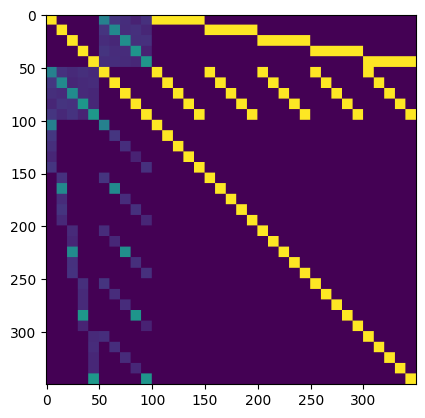

In [73]:
plt.imshow(th_cond_matrix)

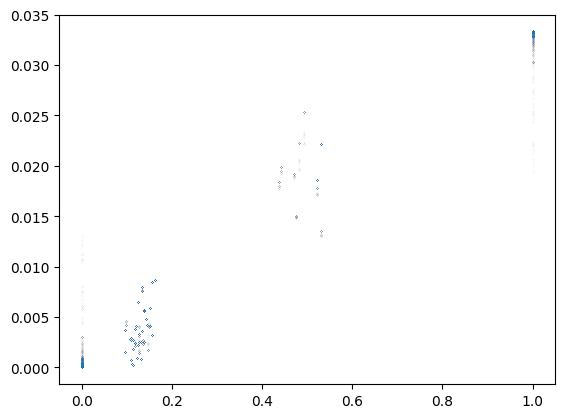

In [83]:
plt.scatter(th_cond_matrix.flatten(), network.ctx_ctx[full_ordered_indices_ctx][:, full_ordered_indices_ctx].flatten(), s=0.00001)